In [11]:
import glob,os
import rasterio as rio
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_image,reshape_as_raster
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
training_path = "Input/sentinel/test_data_from_drive/patches_all/all_states/"
training_normalised_path = "Input/sentinel/test_data_from_drive/patches_all/all_states_normalised_b2_b8_b11/"

# training_normalised_path2 = "Input/sentinel/test_data_from_drive/patches_all/normalised_test_v2/"
target_file_path = "Input/Target/concat/target_yield.shp"
patch_dim = (256, 256, 13)


In [32]:
training_file_list = glob.glob(os.path.join(training_path,"*.tif"))
target_gdf = gpd.read_file(target_file_path)
print("Total Number of Patches:",len(training_file_list))
ignore_patch_list = list()
file_name = list()
count = 0
x = list()
y = list()
for file in training_file_list:
    patch_src = rio.open(file)

    patch_src_read_norm = list()
    f_name = file.split("/")[-1].split(".")[0]
    
    patch_src_read = reshape_as_image(patch_src.read()) ## Change the index here to add or remove the mask layer
    # print(0)
    if patch_src_read.shape != patch_dim:
        ignore_patch_list.append(f_name)
        # print("Patch Dimensions Mismatch, skipping patch : {}".format(f_name))
        continue
    # print(1)
    if np.isnan(patch_src_read).any():
        # print("Has Nan values, skipping patch : {}".format(f_name))
        continue
    # print(2)
    query = target_gdf.query(f"patch_name == '{f_name}'")["ykg_by_e7"]
    if len(query) != 1:
        # print("patch has no target value, skipping patch : {}".format(f_name))
        continue
    # print(patch_src_read.shape)
    file_name.append(f_name)
    # Just get blue (Band 2- index 1), NIR (Band 8 - index 7) and SWIR  (Band 11 - index10) 
    # since they are the ones used to monitor healthy crops in agriculture
    blue_band = patch_src_read[:,:,1]
    nir_band = patch_src_read[:,:,7]
    swir1_band = patch_src_read[:,:,10]
    
    patch_agri_bands = np.dstack((blue_band,nir_band,swir1_band))
    # patch_agri_bands = np.dstack(
    
    # x.append(patch_src_read[:,:,1])
    x.append(patch_agri_bands)

    y.append(patch_src_read[:,:,12])
    # for band_no in range(0,12):
    #     scaler = MinMaxScaler(feature_range=(0, 1))
    #     scaler.fit(patch_src_read[:,:,band_no])
    #     patch_src_read_norm.append(scaler.transform(patch_src_read[:,:,band_no]))
    # patch_src_read_norm.append(patch_src.read()[12,:,:])
    # patch_src_read_norm = np.array(patch_src_read_norm)
    # print(patch_src_read_norm.shape)
    # print("Minimum: ",patch_src_read_norm.min())
    # print("Maximum: ",patch_src_read_norm.max())
    patch_src.close()
    # print(count)
    # outpath = training_normalised_path+"/"+f_name+".tif"
    # meta = patch_src.meta.copy()
    # with rio.open(outpath, 'w', **meta) as outds:
    #     outds.write(patch_src_read_norm)
    count +=1
    # if count > 5:
    #     break
y = np.array(y)
y = np.expand_dims(y,-1)
x = np.array(x)

# x = (x-np.min(x))/(np.max(x)-np.min(x))
print("Any Null values? ",np.isnan(x).any())
# print(self.y)
# self.x = np.nan_to_num(self.x, nan=0)# Check for different value for no data
print(f"x shape :{x.shape}, y shape: {y.shape}")
# print(np.nanmin(self.x),np.nanmax(self.x))
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

Total Number of Patches: 25384
Any Null values?  False
x shape :(14370, 256, 256, 3), y shape: (14370, 256, 256, 1)


In [33]:
x.max()

1.8603

In [34]:
x.min()

1e-04

In [35]:
x = (x-np.min(x))/(np.max(x)-np.min(x))

In [36]:
print("x shape:",x.shape)
print("min:", x.min())
print("max:", x.max())

x shape: (14370, 256, 256, 3)
min: 0.0
max: 1.0


In [37]:
x[2,:,:,2].min()

0.0

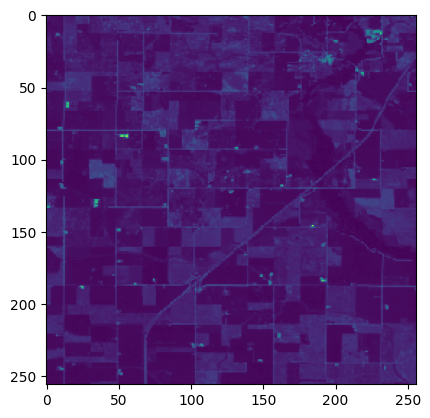

In [38]:
plt.imshow(x[2,:,:,0])

In [39]:
len(file_name)

14370

In [40]:
patch_dict = dict()
count = 0
for patch_no in range(x.shape[0]):
    patches = np.dstack((x[patch_no],y[patch_no]))
    patch_dict[file_name[patch_no]] = patches
    count+=1
    # if count > 10:
    #     break

In [32]:
# patch_dict.keys()

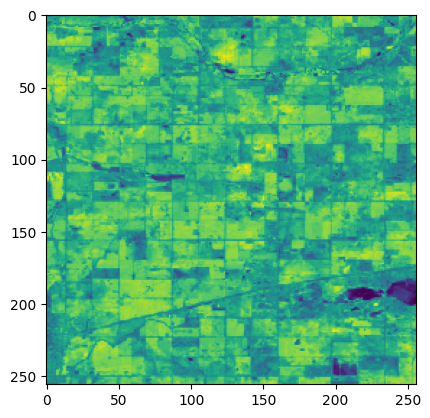

In [42]:
import matplotlib.pyplot as plt
plt.imshow(patch_dict["Iowa_2019_july_5632-512"][:,:,1])

In [63]:
# patch_dict

In [43]:
training_file_list = glob.glob(os.path.join(training_path,"*.tif"))
target_gdf = gpd.read_file(target_file_path)
print("Total Number of Patches:",len(patch_dict))
ignore_patch_list = list()
file_name = list()
count = 0
for f_name,patch in patch_dict.items():
    
    file = glob.glob(training_path+f_name+".tif")[0]
    patch_src = rio.open(file)
    outpath = training_normalised_path+"/"+f_name+".tif"
    meta = patch_src.meta.copy()
    meta.update(count=4)
    with rio.open(outpath, 'w', **meta) as outds:
        outds.write(reshape_as_raster(patch_dict[f_name]))
    count+=1
    # if count > 10:
    #     break
print("Done")

Total Number of Patches: 14370
Done


In [ ]:
   #
    patch_src_read_norm.append(patch_src.read()[12,:,:])
    # patch_src_read_norm = np.array(patch_src_read_norm)
    # print(patch_src_read_norm.shape)
    # print("Minimum: ",patch_src_read_norm.min())
    # print("Maximum: ",patch_src_read_norm.max())
    patch_src.close()
    # print(count)
    outpath = training_normalised_path+"/"+f_name+".tif"
    meta = patch_src.meta.copy()
    # with rio.open(outpath, 'w', **meta) as outds:
    #     outds.write(patch_src_read_norm)